In [490]:
print("Hello World")
DEBUG = False

Hello World


In [2]:
import spacy
import os
import subprocess
import langid
import csv, json, ast, requests
import numpy as np
import datetime
import string
from collections import Counter
import copy
import requests

In [3]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction import text as sklearn_text
from scipy.cluster.hierarchy import cophenet, dendrogram
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster
from scipy import cluster
from sklearn.neighbors import kneighbors_graph
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [4]:
from functools import reduce

In [5]:
#Tokenizing Methods
from nltk import word_tokenize

In [6]:
#Import stop words
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as en_stopwords

In [7]:
#Import matplotlib for visualization of t-SNE
from matplotlib import colors as mcolors
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import mplcursors


In [8]:
#Vadersentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [9]:
import shutil

In [10]:
#..to be wrapped using .sh script
print("All Imports Completed!")

All Imports Completed!


In [11]:
### .shell script for downloading glove embeddings
# download word vector
"""
if [ ! -e $WORDFILE ]; then
wget http://nlp.stanford.edu/data/glove.840B.300d.zip
unzip glove.840B.300d.zip -d $DATADIR
rm glove.840B.300d.zip
fi
"""

'\nif [ ! -e $WORDFILE ]; then\nwget http://nlp.stanford.edu/data/glove.840B.300d.zip\nunzip glove.840B.300d.zip -d $DATADIR\nrm glove.840B.300d.zip\nfi\n'

In [12]:
## input
# word vector file, can be downloaded from GloVe website
wordfile = 'data/glove.840B.300d.txt'
# each line is a word and its frequency; can be made from corpus
weightfile = 'auxiliary_data/enwiki_vocab_min200.txt' 
weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme
output_folder = 'output_docs/'
filing_list = 'filing_list.txt'
output_jsons_path = 'all_slices_json.txt'

In [13]:
#DEBUG = True
DEBUG = False
import params

def load_params(params, wordfile, weightfile, weightpara, rmpc, output_folder, filing_list, output_jsons_path):
    cwd = os.getcwd()+'/'
    params.wordfile = cwd+wordfile
    params.weightfile = cwd+weightfile
    params.weightpara = weightpara
    params.rmpc = rmpc
    params.output_folder = cwd+output_folder
    params.filing_list = filing_list
    params.output_jsons_path = cwd+output_jsons_path
    params.is_output_jsons = False
    params.output_jsons = None
    params.stopwords = en_stopwords
    params.my_model = None

In [14]:
if(DEBUG):
    #Print current directory
    print(os.getcwd())

    #Load params
    params = params.params()
    load_params(params, wordfile, weightfile, weightpara, rmpc, output_folder, filing_list, output_jsons_path)

In [15]:
#TODO: Run on Stanford Cloud Service
#TODO: Try iterator pattern for better performance
#Note:
#          returns only the newly updated list of files and jsons.
#          need to read from files directly to obtain the whole set;
#           or set is_new_filing_list=True.

def get_FCC_docs_(myAPIKey, params, is_new_filing_list=False, is_new_folder=False, attachments=False, 
                  start_ind=0, end_ind=-1):
    def unpopulate_filing_list(params):
        with open(filing_list_path, 'w') as fl:
            fl.write('')
            
    APIUrl = "https://publicapi.fcc.gov/ecfs/"
    raw_APIKey = myAPIKey
    """
    try: #check for api key
        raw_APIKey = sys.argv[1]
    except (ValueError, IndexError):
        raise ValueError("Invalid API key")
    """
    APIKey = "&api_key="+raw_APIKey
    
    #forming query
    url = APIUrl + 'filings?proceedings.name=17-108'+'&type=downloadplan'+APIKey
    if(DEBUG): print(url)
    response = requests.get(url)
    parsed = response.json()
    
    if os.path.exists(params.output_folder):
        if(is_new_folder):
            shutil.rmtree(params.output_folder)
            os.makedirs(params.output_folder)
    else:
        os.makedirs(params.output_folder)
    
    #make filing list
    filing_list_path = params.output_folder+params.filing_list
    if not os.path.exists(filing_list_path) or is_new_filing_list:
        unpopulate_filing_list(params)
        existing_file_names = []
    else:
        with open(params.output_folder+params.filing_list, 'r') as fd:
            existing_file_names = [file_name.strip() for file_name in fd.readlines()]
        
    #get download plan in json
    downloadplan_path = params.output_folder+'downloadplan.txt'
    if not os.path.exists(downloadplan_path):
        with open(downloadplan_path, 'w') as dpp:
            dpp.write('')
    
    #get parsed documents
    parsed_list = []
    for doc in parsed['aggregations']['download_plan']['buckets']:
        parsed_list.append(doc)
        
    my_file_slice_key_list = []
    my_file_slice_json_list = []
    doc_count = 0
    

    for doc in parsed_list[start_ind:end_ind]:
        if(DEBUG): 
            print(doc_count)
            #if(doc_count == 3): break
                
        doc_count += 1
        file_slice = str(doc['key'])
        #print(json.dumps(doc, indent=4, sort_keys=True))
                
        if doc['suggested_api_call']:
            for local_count, api_call in enumerate(doc['suggested_api_call']):
                file_slice_key = file_slice + str(local_count)+'.txt'
                
                #avoiding requesting duplicate files
                if(DEBUG): print(existing_file_names)
                if file_slice_key not in existing_file_names:
                    my_file_slice_key_list.append(file_slice_key)
                else:
                    break;
                
                #API Call
                api_call_key = api_call+APIKey
                print('-->' + api_call_key)
                slice_req = requests.get(api_call_key, stream=True)
                
                #overwrite even if it exists
                file_slice = open(params.output_folder+file_slice_key, 'wb+')
                for chunk in slice_req.iter_content(chunk_size=256):
                    if(chunk):
                        file_slice.write(chunk)
                
                ##Checking Rate Limit
                file_slice.seek(0)
                temp_read = json.load(file_slice)
                file_slice.close()
                if(DEBUG): print(temp_read.keys()) #if request limit exceeds, return.
                if('error' in temp_read.keys()):
                    print('{0}: request limit exceeded. Error: {1}'.format(count, temp_read['error']))
                    return my_file_slice_key_list, my_file_slice_json_list
                
                
                my_file_slice_json_list.append(temp_read)
                
                #recording the name of the file
                if(is_new_filing_list):
                    with open(filing_list_path, 'w') as fd:
                        fd.write(file_slice_key+'\n')
                else:
                    with open(filing_list_path, 'a') as fd:
                        fd.write(file_slice_key+'\n')
    
    with open(params.output_jsons_path, 'w') as fd:
        fd.write(json.dumps(my_file_slice_json_list))
        
    params.output_jsons = my_file_slice_json_list
    params.output_file_name_list = my_file_slice_key_list

    params.is_output_jsons = True
    return my_file_slice_key_list, my_file_slice_json_list

In [16]:
if(DEBUG):
    myAPIKey = 'wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr'
    file_slice_list, file_slice_json = get_FCC_docs_(myAPIKey, params, is_new_filing_list=True, attachments=False, start_ind=2, end_ind=5)

In [17]:
#successfully saved all jsons in one text file.
#This means we need not use the resulting json.
if(DEBUG):
    params.is_output_jsons

In [112]:
#IDEA: Build a class for text-tree that has 
#raw, rare, filtered, doc_index, file_index
def load_params_json(params):
    try:
        with open(params.output_jsons_path, 'r') as fd:
            params.output_jsons = json.load(fd)
            params.is_output_jsons = True
        return True
    except:
        return False

In [98]:
load_params_json(params)

True

In [106]:
print(params.output_jsons[0].keys())

dict_keys(['filings', 'aggregations'])


In [108]:
#all_slices_json_f = open(output_jsons, 'r')
#all_slices_json = json.load(all_slices_json_f)
#print(file_slice_json[0]['filings'][1])

#Turn off local reading of jsons by setting:
# params.is_output_jsons = False
# TODO: pre-load all jsons from separate jsons in output_folder into one list
def wrap_data(params, ignore_docs=False):
    new_data = []
    
    #if doesn't exist, load the most recent (if exists)
    try:
        if not params.is_output_jsons:
            load_params_json(params)
        print('Using most recent successful case of json production.')
    except:
        pass
    
    if params.is_output_jsons:
        total_count = 0
        for doc_index, doc_json in enumerate(params.output_jsons):
            
            if('filings' not in doc_json):
                print('!! filing not present..')
                print(doc_json.keys())
            
            if(DEBUG): print(doc_index, doc_json.keys())

            for file_index, data in enumerate(doc_json['filings']):
                if(file_index % 1000 == 0): print(file_index)
                wrapped_data = {}  

                keys = data.keys()
                #total filing index
                wrapped_data['tag'] = total_count
                total_count += 1
                
                #submission type
                wrapped_data['submission_type'] = data['submissiontype']['description']
                #wrapped_data['confirmation_number'] = data['confirmation_number']
                wrapped_data['id_submission'] = data['id_submission']
                #wrapped_data['address'] = data['addressentity']
                #wrapped_data['data_received'] = data['data_received']
                #wrapped_data['contact_email'] = data['contact_email']
                #wrapped_data['filer'] = data['filer']
                #wrapped_data['filing_status'] = data['filing_status']
                wrapped_data['is_text_data'] = False
                wrapped_data['is_doc_data'] = False
                wrapped_data['is_public_notice'] = False
                ##Importing text/documents/attachments
                
                ###text data
                if(wrapped_data['submission_type'] == 'COMMENT'):
                    if('text_data' in data):
                        wrapped_data['is_text_data'] = True
                        wrapped_data['filtered_text_data'] = my_filter_text(params, data['text_data'], full_filter_text)
                        wrapped_data['rare_text_data'] = my_filter_text(params, data['text_data'], raw_filter_text)
                        wrapped_data['raw_text_data'] = my_filter_text(params, data['text_data'])
                        wrapped_data['doc_index'] = doc_index
                        wrapped_data['file_index'] = file_index
                        
                    if(ignore_docs==False and 'document' in data):
                        wrapped_data['is_doc_data'] = True
                        doc_text_list = []
                        doc_raw_text_list = []
                        #doc_embedding_list = []
                        for doc in data['document']:
                            #forming query
                            url = 'https://ecfsapi.fcc.gov/file/'+ wrapped_data['id_submission'] + doc['filename'].replace(' ', '%20')
                            print(url)
                            response = requests.get(url)
                            parsed = response.text
                            
                            filtered_text = filter_text(parsed, en_stopwords_list)
                            doc_text_list += filtered_text
                            doc_raw_text_list.append(parsed)
                            #doc_embedding_list.append(apply_embedding(model, filtered_text))
                        
                        wrapped_data['doc_text_list'] = doc_text_list
                        wrapped_data['doc_raw_text_list'] = doc_raw_text_list
                        #wrapped_data['doc_embedding_list'] = doc_embedding_list
                
                if(wrapped_data['submission_type'] == 'PUBLIC NOTICE'):
                    wrapped_data['is_public_notice'] = True
                
                if(wrapped_data['is_text_data']):
                    new_data.append(wrapped_data)
                
        return new_data
    else:
        #the connection failed or the filing scrapping was interrupted.
        #TODO: directly call from all files in output_folder.
        print('Please re-complete the filing scrapping at this current version.')
        return;


In [20]:
if(DEBUG):
    wrapped_data_list = wrap_data(params, ignore_docs=True)


In [21]:
if(DEBUG):
    print(len(wrapped_data_list))
    print(wrapped_data_list[10])

In [22]:
from sklearn.metrics.pairwise import cosine_similarity as cos_sim

In [23]:
import hashlib
def getMD5_from_file(filename, block_size=4096):
    md5 = hashlib.md5()
    try:
        with open(filename, 'rb') as f:
            while True:
                data = f.read(block_size)
                if not data:
                    break
                md5.update(data)
    except IOError:
        print('File' + filename + 'Not found!' )
        return None
    except:
        return None
    return md5.hexdigest()

def getMD5_from_text(text):
    md5 = hashlib.md5()
    md5.update(text.encode('utf-8'))
    return md5.hexdigest()

In [24]:
if(DEBUG):
    getMD5_from_text('I wonder why')

In [207]:
import text_chunk #THIS IS UNDER CONSTRUCTION
import collections

def extract_text_data(wrapped_data_list, sub_type='COMMENT', allow_duplicate=False, len_lim=99999):
    #my_chunk = text_chunk.text_chunk()
    selected_wrapped_data = []
    raw_text_list = []
    rare_text_list = []
    filtered_text_list = []
    my_hash_countable = {}
    my_hash_rawtable = {}
    
    #!could handle all sub_types: TEXT_ONLY, DOC_ONLY, ALL
    for cnt, wrapped_data in enumerate(wrapped_data_list):
        #if(cnt == 3): break
        if(wrapped_data['submission_type'] == sub_type):
            if(wrapped_data['is_text_data']):
                #USE staticmethod?
                #my_chunk.temp_wrapped_data = wrapped_data
                #my_chunk.temp_allow_duplicate = allow_duplicate
                #no_duplicate = my_chunk.add_all_dict()
            
                #We can be as strict as to check raw_text, or as loose as filtered_text. 
                #returns: whether if the text passed the duplicate test.
                test_sent = wrapped_data['rare_text_data']
                my_hash = getMD5_from_text(test_sent)
                
                if allow_duplicate or (my_hash not in my_hash_countable and len(test_sent) < len_lim):
                #kinda NOR operation
                #can't directly compare strings.
                #if allow_duplicate or test_sent.split() not in [raws.split() for raws in raw_text_list]:
                    #print(raw_text_list[-1].split() == test_sent.split())
                   
                    #print(len(raw_text_list))
                    
                    #print(test_sent)
                    #print(my_hash)
                    raw_text_list.append(wrapped_data['raw_text_data'])
                    rare_text_list.append(wrapped_data['rare_text_data'])
                    filtered_text_list.append(wrapped_data['filtered_text_data'])
                    selected_wrapped_data.append(wrapped_data)
                    
                    if(my_hash not in my_hash_countable):
                        my_hash_countable.update({my_hash:1})
                        my_hash_rawtable.update({my_hash: wrapped_data['raw_text_data']})
                    else:
                        my_hash_countable[my_hash] += 1
                        
            #TODO: filtering doc text need to be fixed in wrapping.
            """
            if(wrapped_data['is_doc_data']):
                all_docs = ''
                for doc in wrapped_data['doc_text_list']:
                    all_docs += doc
                text_chunk.add_raw_text(all_docs)
            """
    if(allow_duplicate):
        my_cnt = 0
        duplicate_list=[]
        for k,v in sorted(my_hash_countable.items(), key= lambda kv: kv[1], reverse=True): 
            if(my_cnt == 3000 or v == 1):
                break
            print('Top {0} comment'.format(my_cnt+1))
            print('_hash name: {0}\n_repeat_count: {1}\n_text_data: \n{2}\n\n'.format(k, v, my_hash_rawtable[k]))
            #print(k,v, my_hash_rawtable[k])
            my_cnt += 1
            duplicate_list.append({'text':my_hash_rawtable[k], 'count':v})
            
            
        #constantly updating bot_detected_list
        #with open('bots_raw_texts.json', 'w') as bot_f:
        #    json.dump(duplicate_list, bot_f)
            
    print(len(raw_text_list))
    #print(raw_text_list)
    my_text_chunk = [raw_text_list, rare_text_list, filtered_text_list]
    return selected_wrapped_data, my_text_chunk

In [26]:
if(DEBUG):
    selected_wrapped_data, my_text_chunk = extract_text_data(wrapped_data_list, allow_duplicate=False)

In [27]:
with open('bots_raw_texts.json', 'r') as bot_f:
    my_json_list = json.load(bot_f)
    print(len(my_json_list))
    for my_json in my_json_list:
        print(my_json)

3000
{'text': 'I was outraged by the Obama/Wheeler FCC\'s decision to reclassify the Internet as a regulated "public utility" under a Depression-era law written for the old Ma Bell telephone monopoly.\n\nGovernment utility regulation of the Internet risks devastating private investment, undermining competition, and stalling innovation. It also puts consumers at serious risk of being hit with a new "broadband tax" to cover the lack of private sector investment due to these regulations.\n\nThe liberal extremist groups that ginned up fake support for reclassification include the group Free Press, which was cited 62 times in the Title II order.\n\nFree Press was founded by ultraliberal college professor Robert McChesney who has admitted: "At the moment, the battle over network neutrality is not to completely eliminate the telephone and cable companies. We are not at that point yet. But the ultimate goal is to get rid of the media capitalists in the phone and cable companies and to divest t

{'text': 'I support Net Neutrality under the Title II regulations.', 'count': 15}
{'text': 'I support strict net neutrality rules backed by title II. The idea that ISPs can simply give us their word that they will abide by net neutrality rules, as proposed by Pai, is as ludicrous as a bank with no locks acting on the honor system.', 'count': 15}
{'text': "ISPs should continue to be regulated under Title II. As a software engineer and entrepreneur the protections provided by Net Neutrailty allow me, and many others, to compete with established corporations and continue innovating. The incredible technological progress that has spawned from Silicon Vally's internet companies will be extinguished if the Title II protections are stripped away.", 'count': 15}
{'text': 'Please keep them in article 2', 'count': 15}
{'text': 'I support net neutrality, and the Title II classification of internet services. ISPs should not be able to pick winners and losers on the internet. Their services should 

{'text': 'Do not loosen or take away regulations when it comes to net neutrality.  Everyone should have free internet, everyone should have a chance.  It is wrong to let one company exclude another.  The American people should be able to choose what they watch and not have it predetermined by internet speeds.', 'count': 8}
{'text': 'Keep ISPs on Title II. We need regulations on ISPs to make sure that Net Neutrality remains in place.', 'count': 8}
{'text': 'Title II protects consumers from nefarious internet manipulation by corporate interests.\nI fully support and demand that net neutrality remain the norm. Our rights to use this vital service in an unmanipulated way will be severely compromised if net neutrality becomes a victim of deregulation!', 'count': 8}
{'text': 'Please don\'t allow this to be taken lightly . it\'s important that we the consumer have rights when it concerns freedom to choose what content is available when using the internet !!! \nDon\'t allow a George "ORWELLIAN

{'text': 'Please keep title 2 net neutrality.', 'count': 7}
{'text': 'The premise of net neutrality is essentially for a free and open internet.  Allowing ISPs to "meter" internet content will be the beginning of a slippery slope that will allow Big Business to regulate information the general public.  It will also allow large  corporations to snuff out small business and start ups by throwing huge sums of money at ISP in order monopolize there market.  \n\nFor these reasons I ask that you do not allow the repeal of this important regulation.', 'count': 7}
{'text': 'I support the enforcement of strong net neutrality rules under Title II of the Communications Act.', 'count': 7}
{'text': "Equal access to online information is once again under serious threat. Do not turn the internet into a place where business restricts and manipulates it's customers. In rural areas, we we don't have choices in ISPs. Each and every one of us is dependent on reliable internet service for work and home.", 

In [28]:
if(DEBUG):
    #IF duplicates are allowed, both numbers should be the same.
    print(len(wrapped_data_list))
    print(len(selected_wrapped_data), len(my_text_chunk[0]), len(my_text_chunk[1]), len(my_text_chunk[2]))
    print(wrapped_data_list[:4])

In [29]:
if(DEBUG):
    my_text_chunk[1][1]

In [30]:
#return tf-idf matrix and words in tf-idf
#IDEA: could pre-define unigram/bigram vectorizer out of function
def get_tfidf_matrix(text_list, ngram=1, stopwords=None):
    def get_doc_iterator(doc_token_collection, by_sentence=False, indiv_tokens=False, stemmed=False,
                    stopwords=None, filter_fn = lambda x: True, get_key= False, skip_form_letters=False,
                    condense_form_letters=False, get_names=False):
        for sent in doc_token_collection:
            tokens = word_tokenize(sent)
            yield " ".join(tokens)
            #print(tokens, sent.split())  #same thing
            #yield " ".join(sent.split())
            
    
    #DESCRIBING TF-IDF
    #sublinear_tf: Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf).
    #smooth_idf: add-one smoothing.
    #use_idf: Enable inverse-document-frequency reweighting.  
    tfidf_vectorizer = sklearn_text.TfidfVectorizer(min_df=2, stop_words = stopwords, strip_accents = 'unicode', 
                                                lowercase=True, ngram_range=(1,ngram), norm='l2', smooth_idf=True, 
                                                sublinear_tf=False, use_idf=True)
    sklearn_doc_iterator = get_doc_iterator(text_list, indiv_tokens=False, stemmed=False, condense_form_letters=True)
    tfidf_matrix = tfidf_vectorizer.fit_transform(sklearn_doc_iterator)
    words_tfidf = np.array(tfidf_vectorizer.get_feature_names())
    return tfidf_matrix, words_tfidf

In [31]:
if(DEBUG):
    rare_unigram_mat = get_tfidf_matrix(my_text_chunk[0], ngram=1, stopwords=en_stopwords)

In [32]:
if(DEBUG):
    #UNIGRAM
    #raw_unigram_mat = get_tfidf_matrix(my_text_chunk[0], ngram=1)
    rare_unigram_mat_no_stop, rare_unigram_words_no_stop = get_tfidf_matrix(my_text_chunk[1], ngram=1)
    rare_unigram_mat_stop, rare_unigram_words_stop = get_tfidf_matrix(my_text_chunk[1], ngram=1, stopwords=en_stopwords)
    filtered_unigram_mat, filtered_unigram_words = get_tfidf_matrix(my_text_chunk[2], ngram=1, stopwords=en_stopwords)

    #BIGRAM
    #raw_bigram_mat = get_tfidf_matrix(my_text_chunk[0], ngram=1)
    rare_bigram_mat_no_stop, rare_bigram_words_no_stop = get_tfidf_matrix(my_text_chunk[1], ngram=2)
    rare_bigram_mat_stop, rare_bigram_words_stop = get_tfidf_matrix(my_text_chunk[1], ngram=2, stopwords=en_stopwords)

    filtered_bigram_mat, filtered_bigram_words = get_tfidf_matrix(my_text_chunk[2], ngram=2)

In [33]:
if(DEBUG):
    print(rare_unigram_mat_no_stop.shape)
    print(rare_unigram_mat_stop.shape)
    print(filtered_unigram_mat.shape)

In [471]:
#principal components
#Return transformed mat and hierarchy cluster using linkage method.
def reduce_topic_dim(mat, n=100):
    topic_dimensionality = n
    tsvd = TruncatedSVD(topic_dimensionality)
    
    tsvd.fit(mat)
    V_tf = tsvd.components_
    U_tf = tsvd.transform(mat)
    print(V_tf.shape)
    print(V_tf[0])
    print(U_tf.shape)
    print(U_tf[0])
    X = U_tf
    
    return X

In [35]:
def get_hier_cluster_of(X, plot_name=None):
    """
    a measure of how faithfully a dendrogram preserves the pairwise 
    distances between the original unmodeled data points. 
    """
    Z = cluster.hierarchy.linkage(X, 'ward')
    full_dendrogram(Z, plot_name=plot_name)
    c, coph_dists = cophenet(Z, pdist(X))
    print("cophenetic constant is {0}".format(c))
    
    return Z

In [36]:
"Hierarchical clustering:"

def full_dendrogram(Z, plot_name='Hierarchical Clustering Dendrogram'):
    plt.figure(figsize=(10, 6))
    plt.title(plot_name)
    plt.xlabel('sample index')
    plt.ylabel('distance')
    dendrogram(
        Z,
        truncate_mode='lastp',  # show only the last p merged clusters
        p=20,  # show only the last p merged clusters
        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=8.,  # font size for the x axis labels
    )
    plt.show()
    
    

In [37]:
if(DEBUG):
    X_tfidf_rare_uni_no_stop = reduce_topic_dim(rare_unigram_mat_no_stop, 200)
    X_tfidf_rare_uni_stop = reduce_topic_dim(rare_unigram_mat_stop, 200)
    X_tfidf_rare_bi_no_stop = reduce_topic_dim(rare_bigram_mat_no_stop, 200)
    X_tfidf_rare_bi_stop = reduce_topic_dim(rare_bigram_mat_stop, 200)


In [38]:
if(DEBUG):
    print(rare_unigram_mat_no_stop.shape)
    print(X_tfidf_rare_uni_no_stop.shape)

    Z_tfidf_uni_no_stop = get_hier_cluster_of(X_tfidf_rare_uni_no_stop)
    Z_tfidf_uni_stop = get_hier_cluster_of(X_tfidf_rare_uni_stop)
    Z_tfidf_bi_no_stop = get_hier_cluster_of(X_tfidf_rare_bi_no_stop)
    Z_tfidf_bi_stop = get_hier_cluster_of(X_tfidf_rare_uni_stop)

In [468]:
def tsne_coords(
        mat, dim=2, suppress=True):     
    t_start = time.process_time()
    
    # Recommended reduction via PCA or similar:
    #n_components = 50 if mat.shape[1] >= 50 else mat.shape[1]
    #dimreduce = PCA(n_components=n_components)
    #mat = dimreduce.fit_transform(mat) 
    
    # t-SNE:
    final_dimensions = dim
    tsne = TSNE(n_components=final_dimensions, random_state=1, n_iter=2000) #2000 is better, perplexity=50
    np.set_printoptions(suppress=suppress)    
    tsnemat = tsne.fit_transform(mat) 
    
    print(' t-SNE matrix forming took '+ str(time.process_time-t_start) + 'seconds')
    return tsnemat


def tsne_visualize(xyzcoord,
        rownames,
        colors=None,
        output_filename=None,
        figheight=80,
        figwidth=100, 
        plot_name=None):

    indices = list(range(len(rownames)))
    
    # Colors:
    if not colors:
        colors = ['black' for i in indices]   
    
    # Plot values:
    vocab = np.array(rownames)[indices]
    
    # Plotting:
    coords = list(zip(*xyzcoord))
    
    if(len(xyzcoord[0]) == 2):
        xvals, yvals = coords[0], coords[1]

        fig, ax = plt.subplots(nrows=1, ncols=1)
        #fig.set_figheight(max(xvals))
        #fig.set_figwidth(max(yvals))
        
        ax.plot(xvals, yvals, marker='', linestyle='')
        
        # Text labels:
        for word, x, y, color in zip(vocab, xvals, yvals, colors):
            ax.annotate(word, (x, y), fontsize=8, color=color)
   
    if(len(xyzcoord[0]) == 3):
        xvals, yvals, zvals = coords[0], coords[1], coords[2]
        #fig, ax = plt.subplots(111, projection='3d')
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #fig.set_figheight(max(xvals))
        #fig.set_figwidth(max(yvals))
        #fig.set_figwidth(max(zvals))

        
        ax.scatter(xvals, yvals, zvals, c=colors, marker='x')
        # Text labels:
        #for word, x, y, z, color in zip(vocab, xvals, yvals, zvals, colors):
        #   ax.scatter(x,y,z, alpha=0.8, c=color, edgecolors='none', s=30, label=word)

    # Output:
    if output_filename:
        pass
        #TODO: Invalid RGBA argument??
        #plt.savefig(output_filename, bbox_inches='tight')

    if(plot_name):
        plt.title(plot_name)
        
    mplcursors.cursor(hover=True)
    plt.show() 

In [391]:
if(DEBUG):
    test_xy_tfidf_uni_no_stop_dim2 = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop_dim2, plot_name = 'sif'+'_no_stop')


In [41]:
if(DEBUG):
    tsnemat_tfidf_rare_uni_no_stop = tsne_coords(X_tfidf_rare_uni_no_stop)
    tsnemat_tfidf_rare_uni_stop = tsne_coords(X_tfidf_rare_uni_stop)
    tsnemat_tfidf_rare_bi_no_stop = tsne_coords(X_tfidf_rare_bi_no_stop)
    tsnemat_tfidf_rare_bi_stop = tsne_coords(X_tfidf_rare_bi_stop)


In [42]:
if(DEBUG):
    k = 20
    clusters_tfidf_uni_no_stop = fcluster(Z_tfidf_uni_no_stop, k, criterion='maxclust')
    clusters_tfidf_uni_stop = fcluster(Z_tfidf_uni_stop, k, criterion='maxclust')
    clusters_tfidf_bi_no_stop = fcluster(Z_tfidf_bi_no_stop, k, criterion='maxclust')
    clusters_tfidf_bi_stop = fcluster(Z_tfidf_bi_stop, k, criterion='maxclust')


In [43]:
import random
def get_color_data(labels, color_index_hash=None):
    
    if(color_index_hash == None): color_index_hash = lambda x,length: (x%length)
    else: 
        pass
        #color_index_hash = lambda x,length: (x*100+977)%length
        
    raw_color_keys = list(set(mcolors.CSS4_COLORS.keys()))
    #shuffled_raw_color_keys = random.sample(raw_color_keys, len(raw_color_keys))
    
    color_data = [raw_color_keys[color_index_hash(index,len(raw_color_keys))] for index in labels]
    return color_data, raw_color_keys

In [44]:
if(DEBUG):
    color_data_tfidf_uni_no_stop, raw_color_keys = get_color_data(clusters_tfidf_uni_no_stop)
    color_data_tfidf_uni_stop, raw_color_keys = get_color_data(clusters_tfidf_uni_stop)
    color_data_tfidf_bi_no_stop, raw_color_keys = get_color_data(clusters_tfidf_bi_no_stop)
    color_data_tfidf_bi_stop, raw_color_keys = get_color_data(clusters_tfidf_bi_stop)


In [469]:
def plot_tsne(color_data, tsnemat, plot_name=None):
    t_start = time.process_time()
    my_coords = []
    for coord in tsnemat:
        my_coords.append(coord)
            
    my_coords = [np.array(xy) for xy in my_coords]
    #xvals=normalized_converted_timestamps*scaling_factor #should be real time information from data pull.
    tsne_visualize(my_coords, ['x']*len(tsnemat), colors=color_data, 
                   output_filename=plot_name, plot_name=plot_name)
    
    print(' took '+ str(time.process_time() - t_start) + 'seconds')
    return my_coords

In [46]:
if(DEBUG):
    xy_tfidf_uni_no_stop = plot_tsne(color_data_tfidf_uni_no_stop, tsnemat_tfidf_rare_uni_no_stop, plot_name = 'tfidf_uni_no_stop')
    xy_tfidf_uni_stop = plot_tsne(color_data_tfidf_uni_stop, tsnemat_tfidf_rare_uni_stop, plot_name = 'tfidf_uni_stop')
    xy_tfidf_bi_no_stop = plot_tsne(color_data_tfidf_bi_no_stop, tsnemat_tfidf_rare_bi_no_stop, plot_name = 'tfidf_bi_no_stop')
    xy_tfidf_bi_stop = plot_tsne(color_data_tfidf_bi_stop, tsnemat_tfidf_rare_bi_stop, plot_name = 'tfidf_bi_stop')

In [373]:
def get_weighted_average(model, matrix, words, weight_fn=None, size_of_emb=300):
    n_samples = matrix.shape[0]
    embs = np.zeros((n_samples, size_of_emb))
    print(embs.shape)
    not_found_words = {}
    for cnt, row in enumerate(matrix):
        #if(cnt == 6): break
        k = matrix[cnt,:]
        
        weights = np.array(k.data)
        weights = np.array([1 for i in range(len(k.data))])
        
        one_indices = k.indices
        #one_indcies = [1 for i in range(len(k.indices))]
        
        g_embs = []
        g_weights = []
        for cnt2, index in enumerate(one_indices):
            my_word = words[index]
            try:
                g_embs.append(np.array(model[my_word]))
                g_weights.append(np.array(weights[cnt2]))
            except:
                if my_word not in not_found_words:
                    print('word Not Found: {0}'.format(my_word))
                    not_found_words[my_word] = 1
                else:
                    not_found_words[my_word] += 1
                    if(not_found_words[my_word] % 100 == 0):
                        print('word Not Found: {0} hit {1} times'.format(my_word, not_found_words[my_word]))
            
        #print(weights.shape, g_embs.shape)
        g_embs = np.array(g_embs)
        g_weights = np.array(g_weights)
        
        if(len(g_embs) == 0):
            #print("wtf")
            #print(g_weights.dot(g_embs))
            print(cnt)
            embs[cnt, :] = np.array([0 for i in range(size_of_emb)])
        else:
            #print(g_embs.shape)
            #print(g_weights.dot(g_embs))
            embs[cnt, :] = g_weights.dot(g_embs) / np.count_nonzero(g_weights)
        #print(embs[cnt,:])
        if(cnt==847): print(embs[cnt,:])
    return embs

In [48]:

def same_doc(doc1, doc2):
    for index, word in enumerate(doc1.split()):
        if(word != doc2.split()[index]):
            #print(word)
            break
        else:
            #print(word)
            continue
    return True

#print(my_text_chunk[0][0] in [my_text_chunk[0][0], my_text_chunk[0][2]])
#print(my_text_chunk[0][0].split() == my_text_chunk[0][2].split())

In [49]:
if(DEBUG):
    rare_unigram_mat_no_stop.shape

In [50]:
if(DEBUG):
    mybeds = get_weighted_average(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop)
    print(mybeds)

In [51]:
def load_model(wordfile):
    print('Loading Model from {0}'.format(wordfile))
    f = open(wordfile, 'r')
    model = {}
    for cnt, line in enumerate(f):
        #if(cnt == 100): break
        splitLine = line.split()
        
        word_ind=0
        while(True):
            val = splitLine[word_ind]
            try:
                float(val)
                break
            except:
                word_ind += 1
                
        word = ''.join(splitLine[:word_ind])
        #print(word)
        try:
            embedding = np.array([float(val) for val in splitLine[word_ind:]])
        except:
            print('EMBEDDING MISS')
            print(word, embedding)
            break
        model[word] = embedding
    print('Done', len(model), ' words are loaded.')
    return model
#glove_model = load_model(params)

In [52]:
def compute_pc(X, npc=1):
    svd = TruncatedSVD(n_components=npc, n_iter=10, random_state=0)
    svd.fit(X)
    components_ = svd.components_
    print(X.shape)
    return X, components_

In [53]:
def remove_pc(X, npc=1):
    new_X, pc = compute_pc(X, npc)
    #XX = X - X(U^TU)
    #print(new_X.shape,X.shape)
    if npc == 1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [54]:
def do_SIF_embedding(model, my_matrix, words, weight_fn = None, emb_dim=300, npc=1):
    embs = get_weighted_average(model, my_matrix, words, size_of_emb=emb_dim)
    print(embs.shape)
    print(embs)
    if npc > 0:
        embs = remove_pc(embs, npc)
    print(embs.shape)
    return embs

In [55]:
if(DEBUG):
    sif_mat_uni_no_stop = do_SIF_embedding(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop)


In [56]:
if(DEBUG):
    sif_mat_uni_no_stop.shape


In [57]:
if(DEBUG):
    sif_mat_uni_no_stop
    tsnemat_sif_uni_no_stop = tsne_coords(sif_mat_uni_no_stop)
    plot_tsne(None, tsnemat_sif_uni_no_stop, plot_name='SIF')

In [58]:
if(DEBUG):
    #sentence embeddings
    # Use 
    # 1.Manual local word-frequency map
    # 2.Wiki-count word-frequency map
    sif_mat_uni_no_stop = do_SIF_embedding(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop)
    sif_mat_uni_stop = do_SIF_embedding(glove_model, rare_unigram_mat_stop, rare_unigram_words_stop)


In [59]:
if(DEBUG):
    print(sif_mat_uni_no_stop)

In [60]:
if(DEBUG):
    X_sif_uni_no_stop, Z_sif_uni_no_stop = reduce_topic_dim(sif_mat_uni_no_stop, 299)
    X_sif_uni_stop, Z_sif_uni_stop = reduce_topic_dim(sif_mat_uni_stop, 299)

    clusters_tfidf_uni_no_stop = fcluster(Z_sif_uni_no_stop, k, criterion='maxclust')
    clusters_tfidf_uni_stop = fcluster(Z_sif_uni_stop, k, criterion='maxclust')

In [61]:
if(DEBUG):
    tsnemat_sif_uni_no_stop = tsne_coords(sif_mat_uni_no_stop)
    plot_tsne(None, tsnemat_sif_uni_no_stop, plot_name='SIF')

In [62]:
if(DEBUG): print(glove_model['this'])

In [63]:
def do_average(emb):
    return reduce(lambda x,y: x+y, emb)/len(emb)

In [64]:
#apply_fn
def sent2emb(model, sent, apply_fn=None):
    sent = sent.lower().split()
    sent_vec = []
    for cnt, word in enumerate(sent):
        try:
            emb = model[word]
            sent_vec.append(np.array(emb))
            print(word)
        except:
            print('No Embedding Found in the Model.')
    sent_vec = np.array(sent_vec)
    if(apply_fn):
        return apply_fn(sent_vec)
    else:
        return sent_vec

In [65]:
if(DEBUG): 
    example_sent1 = 'This is an example sentence in New York.'
    example_sent2 = 'New York mayor was present!'
    sent_vec = sent2emb(glove_model, example_sent, apply_fn=None)
    print(len(sent_vec))

In [66]:
#params passed on due to stopwords
def full_filter_text(params, text):
    #TODO: ? and ! may be needed in sentiment analysis
    temp_text = text.lower().replace('/', '').replace('!','').replace('?', '').replace(':', '').replace(';', ' ').replace('\r', '').replace('\n', ' ').replace('.', '').replace(',', '').replace('"', '').replace("'", '').replace('(', '').replace(')', '').replace('{', '').replace('}', '').replace('[', '').replace(']', '').replace("can't", "can not").replace("shouldn't", "should not").replace("couldn't", "could not").replace("wouldn't", "would not").replace("wasn't", "was not").replace("don't", "do not").replace("doesn't", "does not").replace("didn't", "did not").replace("hasn't", "has not").replace("haven't", "have not").replace("'ll", " will").replace("I'm", "I am").replace("he's", "he is").replace("she's", "she is").replace("it's", "it is")
    tokens = ' '.join([w for w in temp_text.split(' ') if w.isalpha()]).split(' ')
    if(params.stopwords):
        filtered_tokens = [w for w in tokens if not w in params.stopwords]
    return ' '.join(filtered_tokens)

In [67]:
if(DEBUG): print(full_filter_text(params, example_sent1))

In [68]:
def raw_filter_text(params, text):
    temp_text = text.lower().replace('/', '').replace('!','').replace('?', '').replace(':', '').replace(';', ' ').replace('\r', '').replace('\n', ' ').replace('.', '').replace(',', '').replace('"', '').replace("'", '').replace('(', '').replace(')', '').replace('{', '').replace('}', '').replace('[', '').replace(']', '').replace("can't", "can not").replace("shouldn't", "should not").replace("couldn't", "could not").replace("wouldn't", "would not").replace("wasn't", "was not").replace("don't", "do not").replace("doesn't", "does not").replace("didn't", "did not").replace("hasn't", "has not").replace("haven't", "have not").replace("'ll", " will").replace("I'm", "I am").replace("he's", "he is").replace("she's", "she is").replace("it's", "it is")
    tokens = ' '.join([w for w in temp_text.split(' ') if w.isalpha()]).split(' ')
    return ' '.join(tokens)

In [69]:
def my_filter_text(params, text, filter_fn=None):
    if(filter_fn):
        return filter_fn(params, text)
    else:
        return text

In [70]:
if(DEBUG): print(my_filter_text(params, example_sent1))

In [71]:
def doc2bigram(params, documents, filter_fn=None):
    from gensim.models import Phrases
    from gensim.models.phrases import Phraser

    if(filter_fn):
        sentence_stream = [filter_fn(params, doc).lower().split(' ') for doc in documents]
    else:
        sentence_stream = [doc.lower().split(' ') for doc in documents]

    
    bigram = Phrases(sentence_stream, min_count=1, threshold=2)
    bigram_phraser = Phraser(bigram)

    #print(bigram_phraser)
    
    result_tokens = []
    for sent in sentence_stream:
        tokens_ = bigram_phraser[sent]
        result_tokens.append(tokens_)
    return result_tokens

In [72]:
if(DEBUG):
    b = doc2bigram(params, [example_sent1, example_sent2], raw_filter_text)
    print(b)

In [73]:
def do_visualize(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop, plot_name='',k=10, n=100):
    #test_X_tfidf_rare_uni_no_stop = reduce_topic_dim(rare_unigram_mat_no_stop)
    test_X_tfidf_rare_uni_no_stop = reduce_topic_dim(rare_unigram_mat_no_stop, n)
    test_Z_tfidf_rare_uni_no_stop = get_hier_cluster_of(test_X_tfidf_rare_uni_no_stop)

    test_X_sif_rare_uni_no_stop = do_SIF_embedding(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop)
    test_Z_sif_rare_uni_no_stop = get_hier_cluster_of(test_X_sif_rare_uni_no_stop)
    
    #k=20
    test_tsnemat_tfidf_rare_uni_no_stop = tsne_coords(test_X_tfidf_rare_uni_no_stop)
    test_clusters_tfidf_uni_no_stop = fcluster(test_Z_tfidf_rare_uni_no_stop, k, criterion='maxclust')
    test_color_data_tfidf_uni_no_stop = get_color_data(test_clusters_tfidf_uni_no_stop)
    test_xy_tfidf_uni_no_stop = plot_tsne(test_color_data_tfidf_uni_no_stop, test_tsnemat_tfidf_rare_uni_no_stop, plot_name = 'tfidf'+plot_name)

    test_tsnemat_sif_rare_uni_no_stop = tsne_coords(test_X_sif_rare_uni_no_stop)
    test_clusters_sif_uni_no_stop = fcluster(test_Z_sif_rare_uni_no_stop, k, criterion='maxclust')
    test_color_data_sif_uni_no_stop = get_color_data(test_clusters_sif_uni_no_stop)
    test_xy_sif_uni_no_stop = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop, plot_name='sif'+plot_name)

    #print(test_xy_sif_uni_no_stop)

In [74]:
glove_model = load_model(params.wordfile)


AttributeError: module 'params' has no attribute 'wordfile'

In [208]:
if(DEBUG):
    glove_model['happy']

In [466]:
#demo
#Load params
import params
params = params.params()

## input
# word vector file, can be downloaded from GloVe website
wordfile = 'data/glove.840B.300d.txt'
# each line is a word and its frequency; can be made from corpus
weightfile = 'auxiliary_data/enwiki_vocab_min200.txt' 
weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme
output_folder = 'output_docs/'
filing_list = 'filing_list.txt'
output_jsons_path = 'all_slices_json.txt'

load_params(params, wordfile, weightfile, weightpara, rmpc, output_folder, filing_list, output_jsons_path)

#if params.my_model == None:
#    glove_model = load_model(params.wordfile)
#    params.my_model = glove_model
#glove_model = load_model(params.wordfile)
params.my_model = glove_model

params.is_output_jsons

False

In [209]:
params.is_output_jsons

True

In [ ]:
print(speed_bump)

In [198]:
myAPIKey = 'wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr'

print(params.is_output_jsons)
test_file_slice_list, test_file_slice_json = get_FCC_docs_(myAPIKey, params, is_new_filing_list=True, is_new_folder=False, attachments=False, start_ind=20, end_ind=23)
print(params.is_output_jsons)


False
-->https://publicapi.fcc.gov/ecfs//filings?proceedings.name=17-108&date_submission=[gte]2017-05-08T20:26:00.000Z[lt]2017-05-08T21:01:00.000Z&sort=date_submission,ASC&limit=9724&api_key=wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr
-->https://publicapi.fcc.gov/ecfs//filings?proceedings.name=17-108&date_submission=[gte]2017-05-08T21:01:00.000Z[lt]2017-05-08T21:34:00.000Z&sort=date_submission,ASC&limit=9894&api_key=wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr
-->https://publicapi.fcc.gov/ecfs//filings?proceedings.name=17-108&date_submission=[gte]2017-05-08T21:34:00.000Z[lt]2017-05-08T22:05:00.000Z&sort=date_submission,ASC&limit=9757&api_key=wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr
True


In [204]:
test_wrapped_data_list = wrap_data(params, ignore_docs=True)
print(len(test_wrapped_data_list))

Using most recent successful case of json production.
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
29184


In [341]:
test_selected_wrapped_data, test_my_text_chunk = extract_text_data(test_wrapped_data_list, allow_duplicate=False, len_lim=500)

print(len(test_selected_wrapped_data))
print(len(test_my_text_chunk[0]))

#Constructing TFIDF matrix from 'rare text' with no stopword
rare_unigram_mat_no_stop, rare_unigram_words_no_stop = get_tfidf_matrix(test_my_text_chunk[1], ngram=1,stopwords=None)

print(rare_unigram_mat_no_stop.shape)

#Constructing SIF matrix from 'rare text' with no stopword
rare_unigram_mat_stop, rare_unigram_words_stop = get_tfidf_matrix(test_my_text_chunk[1], ngram=1)

print(rare_unigram_mat_stop.shape)


18895
18895
18895
(18895, 5605)
(18895, 5605)


In [489]:
ncnt = 300
for acnt in range(10):
    print(' batch '+str(acnt+1))
    for pcnt in range(15):
        print('comment #{0}'.format(pcnt+1))
        print(test_my_text_chunk[0][ncnt*15])
        ncnt += 1
    print('\n')

 batch 1
comment #1
Net Neutrality is extremely important to me, and my family. We urge you to keep strong net neutrality rules backed by Title II.
comment #2
Ajit Pai, FCC persons, I support the Title II classification to keep fairness and regulation over the ISPs rather than asking them to promise that they won't do it
comment #3
I demand that net neutrality be restored as well as Title II.
comment #4
Net neutrality should be preserved and Title II classification of ISPs should be maintained under the Communications Act of 1934.
comment #5
I very much support strong net neutrality. Today, when a bulk of all business, academia and entertainment is conducted exclusively through the Internet, it is imperative that we have an equal playing field between all ISPs and ensure that Internet speed and access not be hindered. I support strong net neutrality, now and forever.
comment #6
Please do not allow the big corporations to take over the internet.  The internet should stay neutral and wor

In [ ]:
#do_visualize(params.my_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop, plot_name='_no_stop', k=11, n=200)


In [ ]:
"""
#demo
#Load params
import params
params = params.params()

## input
# word vector file, can be downloaded from GloVe website
wordfile = 'data/glove.840B.300d.txt'
# each line is a word and its frequency; can be made from corpus
weightfile = 'auxiliary_data/enwiki_vocab_min200.txt' 
weightpara = 1e-3 # the parameter in the SIF weighting scheme, usually in the range [3e-5, 3e-3]
rmpc = 1 # number of principal components to remove in SIF weighting scheme
output_folder = 'output_docs/'
filing_list = 'filing_list.txt'
output_jsons_path = 'all_slices_json.txt'

#load_params(params, wordfile, weightfile, weightpara, rmpc, output_folder, filing_list, output_jsons_path)

if params.my_model == None:
    glove_model = load_model(params.wordfile)
    params.my_model = glove_model

myAPIKey = 'wd73djRi6qOZHUHIqCNbuzXo890BrzbrfmdWLfrr'

print(params.is_output_jsons)
test_file_slice_list, test_file_slice_json = get_FCC_docs_(myAPIKey, params, is_new_filing_list=True, is_new_folder=False, attachments=False, start_ind=3, end_ind=5)
print(params.is_output_jsons)
test_wrapped_data_list = wrap_data(params, ignore_docs=True)

print(len(test_wrapped_data_list))

test_selected_wrapped_data, test_my_text_chunk = extract_text_data(wrapped_data_list, allow_duplicate=False)

print(len(test_selected_wrapped_data))
print(len(test_my_text_chunk[0]))
rare_unigram_mat_no_stop, rare_unigram_words_no_stop = get_tfidf_matrix(my_text_chunk[1], ngram=1,stopwords=None)
rare_unigram_mat_stop, rare_unigram_words_stop = get_tfidf_matrix(my_text_chunk[1], ngram=1)

print(rare_unigram_mat_no_stop.shape)
print(rare_unigram_mat_stop.shape)

#do_visualize(rare_unigram_mat_no_stop, rare_unigram_words_no_stop, plot_name='_no_stop', k=11, n=200)
#do_visualize(rare_unigram_mat_stop, rare_unigram_words_stop, k=11)

"""

(50, 5605)
(18895, 50)
[0.0005362  0.00016766 0.00010902 ... 0.00050734 0.00029237 0.00015659]
[ 0.19478324 -0.03850517  0.297542   -0.27438969 -0.13903921  0.05289784
  0.09310715  0.07383818 -0.03205044  0.0016414   0.01414741 -0.05244474
 -0.07584572 -0.07352584  0.07916896 -0.06783721 -0.05580891 -0.05810284
 -0.03698705  0.00798541  0.01480205 -0.0235252  -0.02689937  0.00037457
  0.01059491 -0.00475525 -0.00594838  0.05983275  0.06947295 -0.00580708
  0.01414534  0.03073546  0.01392849 -0.00085101 -0.00049598 -0.03909758
 -0.00470615 -0.01964583 -0.0236072   0.00805803 -0.0037177  -0.02580066
 -0.007192   -0.00794341  0.07606234 -0.03286329  0.04216202  0.00780578
 -0.08086235 -0.03849284]
(500, 5605)
(18895, 500)
[0.0005362  0.00016766 0.00010902 ... 0.00050734 0.00029237 0.00015659]
[ 0.19478324 -0.03850517  0.29754195 -0.27438782 -0.13903963  0.0529041
  0.09311591  0.07382754 -0.03210353  0.00170851  0.01415367 -0.05230967
 -0.07595068 -0.07360775  0.07917875 -0.06780692 -0.0

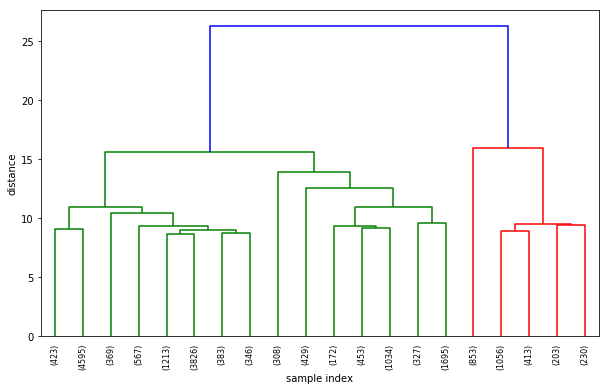

cophenetic constant is 0.38244128418841994


In [444]:
#defining tfidf - part1
t_start = time.process_time()

test_X_tfidf_rare_uni_no_stop1 = reduce_topic_dim(rare_unigram_mat_no_stop, n=50)
print(' took '+ str(time.process_time() - t_start) + 'seconds')

test_X_tfidf_rare_uni_no_stop2 = reduce_topic_dim(rare_unigram_mat_no_stop, n=500)
test_Z_tfidf_rare_uni_no_stop = get_hier_cluster_of(test_X_tfidf_rare_uni_no_stop1)

print(' took '+ str(time.process_time() - t_start) + 'seconds')

(18895, 300)
word Not Found: nutrality
word Not Found: varadaraj
word Not Found: nuetrality
word Not Found: comcasts
word Not Found: neutraility
[-0.10849433  0.11463031 -0.17015768  0.04396044 -0.00447424 -0.08757475
 -0.04469947 -0.05571418  0.02130008  2.36962821 -0.25549732 -0.00936385
  0.02585845  0.00698724 -0.0861439  -0.04474309 -0.11024168  1.23259026
 -0.24391962  0.10137221  0.01806885  0.00647364 -0.08855474 -0.03298286
 -0.01320947 -0.02026444  0.00063817 -0.06956581  0.02131378 -0.02191519
 -0.02773237  0.11487237 -0.07728595  0.06209063  0.08094491 -0.09830712
 -0.05926577  0.07745822  0.02869092 -0.09733507 -0.00506738  0.08087051
  0.05622109 -0.05341331 -0.0103242   0.06755848 -0.03719156  0.05980892
 -0.00041681  0.05959377 -0.07118855  0.02995294 -0.04453638 -0.03259678
  0.06950809  0.0229075  -0.05735665 -0.08384593  0.01034293 -0.0609173
  0.00131529  0.0292029   0.02755305  0.19143579  0.19498596  0.03184923
  0.02693098  0.0689802   0.09926902 -0.01913004  0.1

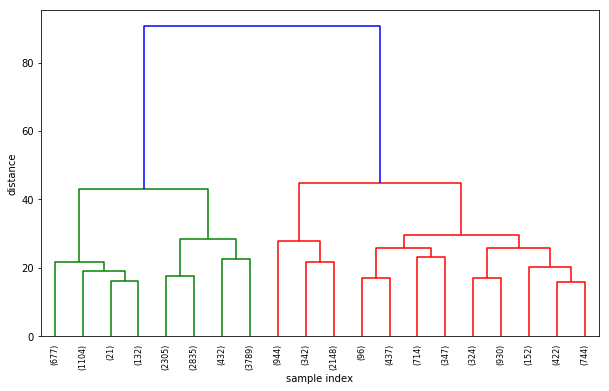

cophenetic constant is 0.3332861584221832


In [446]:
#defining sif - part2-final
t_start = time.process_time()

test_X_sif_rare_uni_no_stop = do_SIF_embedding(glove_model, rare_unigram_mat_no_stop, rare_unigram_words_no_stop)
test_X_sif_rare_uni_no_stop_reduced = reduce_topic_dim(test_X_sif_rare_uni_no_stop, n=200)

test_Z_sif_rare_uni_no_stop = get_hier_cluster_of(test_X_sif_rare_uni_no_stop)

print(' took '+ str(time.process_time() - t_start) + 'seconds')

In [450]:
#Defining clusters for tfidf and sif
## Hierarchical clustering
test_clusters_tfidf_uni_no_stop = fcluster(test_Z_tfidf_rare_uni_no_stop, k, criterion='maxclust')
test_color_data_tfidf_uni_no_stop, raw_color_keys1 = get_color_data(test_clusters_tfidf_uni_no_stop)

test_clusters_sif_uni_no_stop = fcluster(test_Z_sif_rare_uni_no_stop, k, criterion='maxclust')
test_color_data_tfidf_uni_no_stop, raw_color_keys1 = get_color_data(test_clusters_tfidf_uni_no_stop)

(100, 300)
(18895, 100)
[-0.02927661 -0.07487458  0.02536185  0.09779071 -0.06630493  0.03269121
  0.03915042  0.03433791 -0.00491482 -0.11517324  0.01287881  0.01962953
  0.01512617  0.090334    0.07266623  0.05157794  0.11011041  0.01417439
  0.056826    0.01687808  0.02234486  0.00746519  0.05948981  0.04915273
  0.01737243  0.01408423 -0.02430573 -0.00911141 -0.02801761  0.04070113
  0.02569094 -0.00206258  0.01265842 -0.00887886 -0.03675342 -0.07939816
 -0.02982157  0.0358931  -0.03830066 -0.04775235  0.0981906   0.01462242
  0.12870532 -0.00673529  0.05368605 -0.05598913  0.06650979  0.09351035
 -0.00733117  0.0017301   0.06022456  0.0245856  -0.08190248 -0.07380873
 -0.08077841 -0.0245468  -0.051617    0.02583716  0.01780354  0.0061712
 -0.05686405  0.035592    0.04610663 -0.04338094 -0.09751274  0.09510231
  0.11803607 -0.04861884 -0.06136706 -0.16197503 -0.07346827  0.03426727
 -0.08920638  0.04274186  0.00291527 -0.03236752 -0.04450457  0.06493716
 -0.00104585 -0.03267616 -0.

In [217]:
k=15
print(k)

15


In [465]:
test_tsnemat_tfidf_rare_uni_no_stop_50 = tsne_coords(test_X_tfidf_rare_uni_no_stop1)
test_tsnemat_tfidf_rare_uni_no_stop_500 = tsne_coords(test_X_tfidf_rare_uni_no_stop2)
test_tsnemat_sif_rare_uni_no_stop_300 = tsne_coords(test_X_sif_rare_uni_no_stop)
test_tsnemat_sif_rare_uni_no_stop_100 = tsne_coords(test_X_sif_rare_uni_no_stop_reduced)

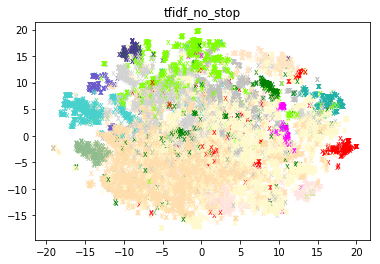

193.40349400000014 seconds


In [462]:
t_start = time.process_time()

#test_tsnemat_tfidf_rare_uni_no_stop1 = tsne_coords(test_X_tfidf_rare_uni_no_stop1)
print('25%')
test_clusters_tfidf_uni_no_stop = fcluster(test_Z_tfidf_rare_uni_no_stop, k, criterion='maxclust')
test_color_data_tfidf_uni_no_stop, raw_color_keys1 = get_color_data(test_clusters_tfidf_uni_no_stop)
print('75%')
test_xy_tfidf_uni_no_stop = plot_tsne(test_color_data_tfidf_uni_no_stop, test_tsnemat_tfidf_rare_uni_no_stop_50, plot_name = 'tfidf'+'_no_stop_50 dim')

t_end = time.process_time()
print(str(t_end-t_start)+' seconds' )

25%
75%


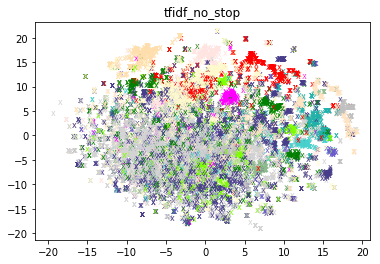

In [339]:
t_start = time.process_time()

#test_tsnemat_tfidf_rare_uni_no_stop2 = tsne_coords(test_X_tfidf_rare_uni_no_stop2)
print('25%')
test_clusters_tfidf_uni_no_stop2 = fcluster(test_Z_tfidf_rare_uni_no_stop, k, criterion='maxclust')
test_color_data_tfidf_uni_no_stop2, raw_color_keys2 = get_color_data(test_clusters_tfidf_uni_no_stop2)
print('75%')
test_xy_tfidf_uni_no_stop = plot_tsne(test_color_data_tfidf_uni_no_stop2, test_tsnemat_tfidf_rare_uni_no_stop2, plot_name = 'tfidf'+'_no_stop')

t_end = time.process_time()
print(str(t_end-t_start)+' seconds' )

25%
75%


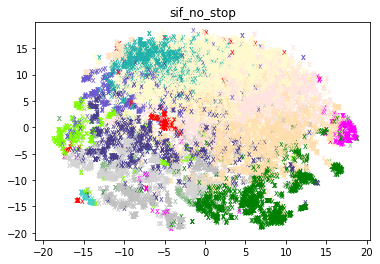

In [340]:
t_start = time.process_time()

#test_tsnemat_sif_rare_uni_no_stop = tsne_coords(test_X_sif_rare_uni_no_stop)
print('25%')
test_clusters_sif_uni_no_stop = fcluster(test_Z_sif_rare_uni_no_stop, k, criterion='maxclust')
test_color_data_sif_uni_no_stop, raw_color_keys3 = get_color_data(test_clusters_sif_uni_no_stop)
print('75%')
test_xy_sif_uni_no_stop = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop, plot_name='sif'+'_no_stop')

t_end = time.process_time()
print(str(t_end-t_start)+' seconds' )

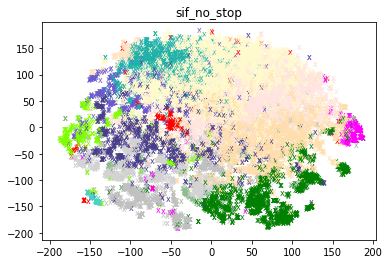

 took 44.52030999999988seconds


In [470]:
test_xy_sif_uni_no_stop = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop*10, plot_name='sif'+'_no_stop')


In [ ]:
for cnt, row in enumerate(test_X_sif_rare_uni_no_stop):
    if(sum(row) == 0):
        #print(test_X_sif_rare_uni_no_stop[3712])
        print(test_my_text_chunk[0][cnt])
        print(' ')
        print(cnt)
        print(sum(rare_unigram_mat_no_stop[cnt].toarray()[0]))
        print(' ')
        print(test_X_tfidf_rare_uni_no_stop2[cnt])
        print(test_X_sif_rare_uni_no_stop[cnt])
        print(test_X_sif_rare_uni_no_stop_reduced[cnt])
        print(test_tsnemat_sif_rare_uni_no_stop[cnt])
        print(' ')
        print('\n')

In [283]:
test_tsnemat_sif_rare_uni_no_stop.shape

(16501, 2)

In [312]:
import time

#up to 4 arguments at max
def runtime_(fn=None, args=None):
    
    if(fn==None):
        print('No function given.')
        return ;
    
    print(fn.__name__)
    start_time = time.process_time()
    
    try:
        if(len(args) == 1):
            result = fn(args[0])
        elif(len(args) == 2):
            result = fn(args[0], args[1])
        elif(len(args) == 3):
            result = fn(args[0], args[1], args[2])
        elif(len(args) == 4):
            result = fn(args[0], args[1], args[2], args[3])
    except:
        print('Unmatching number of arguments. The ')
        return ;
    
    end_time = time.process_time()
    print(' Average Run Time:'+str(round(end_time-start_time,5)))
    
    return result

In [321]:
test_X_sif_rare_uni_no_stop.shape

(16501, 300)

In [472]:
#3D Plotting Testing!
# ask on stackoverflow how to make the interactive smooth because 10000+, 100+ matrix is going to be laggy w/o opt.
import time
#past_runtimes
start_time = time.process_time()
#test_tsnemat_sif_rare_uni_no_stop_dim2 = tsne_coords,test_X_sif_rare_uni_no_stop, dim=2)
test_tsnemat_sif_rare_uni_no_stop_dim3 = tsne_coords(test_X_sif_rare_uni_no_stop, dim=3)
print('Mid Run Time (sec): '+str(time.process_time() - start_time))
test_tsnemat_sif_rare_uni_no_stop_dim3_reduced = tsne_coords(reduce_topic_dim(test_X_sif_rare_uni_no_stop, n=250), dim=3)
end_time = time.process_time()
print('Total Run Time (sec): '+str(end_time-start_time))

KeyboardInterrupt: 

In [342]:
test_clusters_sif_uni_no_stop = fcluster(test_Z_sif_rare_uni_no_stop, 15, criterion='maxclust')

In [335]:
test_color_data_sif_uni_no_stop_dim3, raw_color_keys4 = get_color_data(test_clusters_sif_uni_no_stop_dim3)

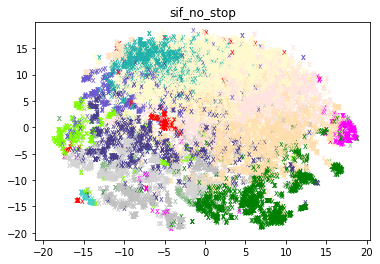

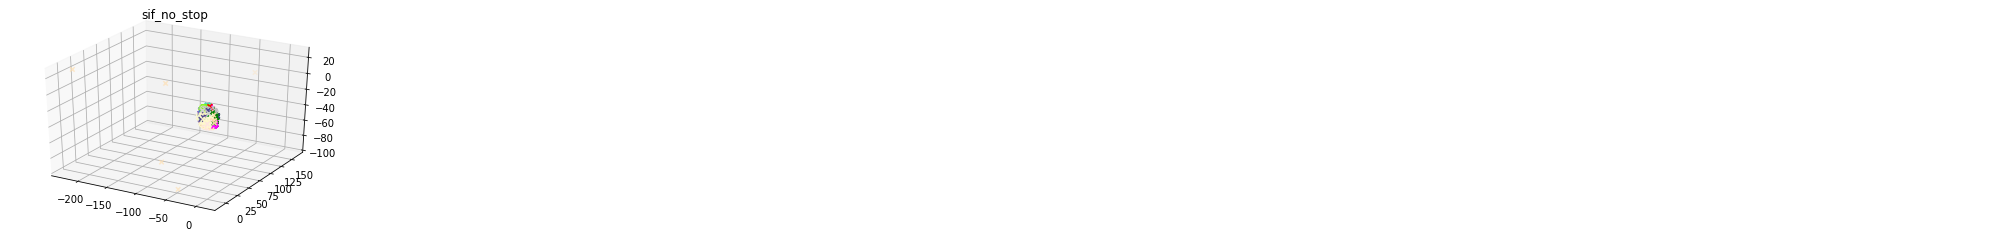

In [345]:
test_xy_sif_uni_no_stop_dim3_reduced = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop_dim3_reduced, plot_name = 'sif'+'_no_stop')


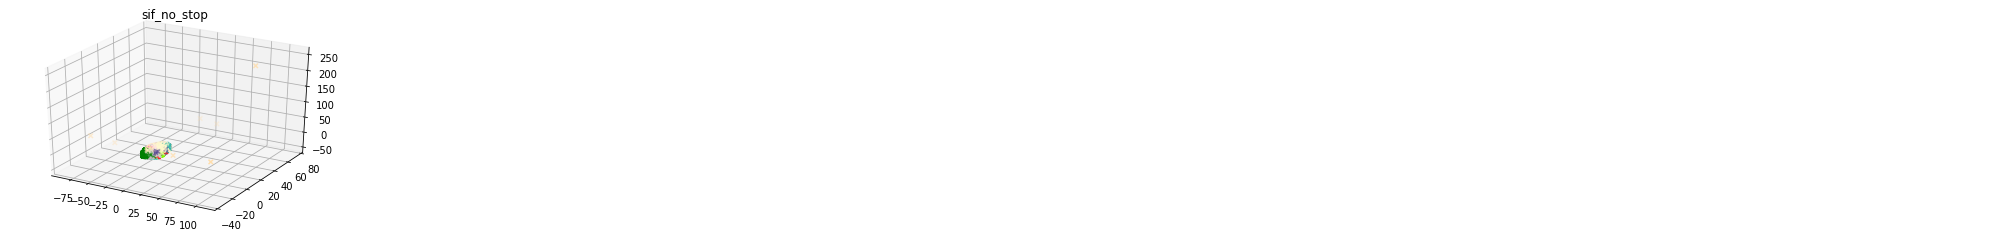

In [346]:
test_xy_sif_uni_no_stop_dim3 = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop_dim3, plot_name = 'sif'+'_no_stop')


In [232]:
test_color_data_sif_uni_no_stop

['red',
 'bisque',
 'bisque',
 'bisque',
 'slateblue',
 'slateblue',
 'mistyrose',
 'lightgray',
 'darkslateblue',
 'darkslateblue',
 'darkslateblue',
 'darkseagreen',
 'darkslateblue',
 'darkslateblue',
 'red',
 'lightgray',
 'slateblue',
 'mediumturquoise',
 'darkslateblue',
 'slateblue',
 'slateblue',
 'darkslateblue',
 'lightgray',
 'bisque',
 'slateblue',
 'mediumturquoise',
 'red',
 'darkslateblue',
 'chartreuse',
 'lightgray',
 'darkseagreen',
 'darkslateblue',
 'chartreuse',
 'mistyrose',
 'darkslateblue',
 'red',
 'bisque',
 'magenta',
 'bisque',
 'slateblue',
 'slateblue',
 'slateblue',
 'chartreuse',
 'darkseagreen',
 'magenta',
 'red',
 'lightgray',
 'darkslateblue',
 'bisque',
 'bisque',
 'darkslateblue',
 'magenta',
 'slateblue',
 'chartreuse',
 'darkslateblue',
 'silver',
 'slateblue',
 'slateblue',
 'bisque',
 'darkslateblue',
 'slateblue',
 'slateblue',
 'silver',
 'bisque',
 'navajowhite',
 'darkslateblue',
 'slateblue',
 'darkseagreen',
 'silver',
 'mistyrose',
 'sla

In [233]:
annotate_clusters(test_my_text_chunk[0], test_X_sif_rare_uni_no_stop, test_color_data_sif_uni_no_stop)

Counter({'darkslateblue': 1589, 'slateblue': 1254, 'lightgray': 874, 'silver': 680, 'darkseagreen': 587, 'mistyrose': 549, 'chartreuse': 549, 'red': 465, 'green': 442, 'bisque': 414, 'magenta': 397, 'mediumturquoise': 209, 'lemonchiffon': 193, 'navajowhite': 138, 'lightseagreen': 67})
{'red': [0, 14, 26, 35, 45, 75, 80, 87, 88, 109, 130, 136, 162, 175, 176, 204, 215, 229, 262, 292, 300, 317, 379, 381, 427, 440, 452, 461, 484, 489, 500, 504, 525, 535, 560, 578, 585, 602, 604, 605, 626, 638, 646, 676, 678, 688, 705, 741, 749, 752, 766, 783, 806, 809, 813, 815, 835, 846, 853, 855, 874, 886, 895, 896, 942, 991, 993, 995, 1035, 1063, 1092, 1093, 1117, 1120, 1132, 1137, 1139, 1157, 1181, 1182, 1186, 1205, 1229, 1250, 1274, 1279, 1286, 1315, 1317, 1327, 1332, 1347, 1356, 1378, 1393, 1397, 1398, 1429, 1430, 1435, 1436, 1440, 1441, 1446, 1457, 1472, 1479, 1483, 1505, 1518, 1528, 1541, 1545, 1564, 1576, 1602, 1619, 1643, 1659, 1698, 1735, 1737, 1746, 1747, 1784, 1786, 1852, 1854, 1879, 1882, 190

300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07221605362541704, nearest_index: 3712
mistyrose
[(0.0, 3712, 

300
nearest_dist: 0.07034493267545042, nearest_index: 3712
chartreuse
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08295746126026873, nearest_index: 3712
silver
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslate

300
nearest_dist: 0.07221605362541704, nearest_index: 3712
mistyrose
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07034493267545042, nearest_index: 3712
chartreuse
[

300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09120617094884327, nearest_index: 3712
navajowhite
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09698664173426116, nearest_index: 3712
mediumturquoise
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06624420184498979, nearest_index: 3712
green
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07221605362541704, nearest_index: 3712
mistyrose
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslat

300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08295746126026873, nearest_index: 3712
silver
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07608588192441057, nearest_index: 3712
darkseagr

300
nearest_dist: 0.07221605362541704, nearest_index: 3712
mistyrose
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.17107177064769782, nearest_index: 3712
lemonchiffon
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09120617094884327, nearest_index: 3712
navajowhite
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 

300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08295746126026873, nearest_index: 3712
silver
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06624420184498979, nearest_index: 3712
green
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09120617094884327, nearest_index: 3712
navajowhite
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07034493267545042, nearest_index: 3712
chartreuse
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateb

300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06624420184498979, nearest_index: 3712
green
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightg

300
nearest_dist: 0.07221605362541704, nearest_index: 3712
mistyrose
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09698664173426116, nearest_index: 3712
mediumturquoise
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09698664173426116, nearest_index: 3712
mediumturquoise
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08295746126026873, nearest_index: 3712


300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06624420184498979, nearest_index: 3712
green
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09120617094884327, nearest_index: 3712
nava

300
nearest_dist: 0.0712407147525407, nearest_index: 3712
bisque
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07608588192441057, nearest_index: 3712
darkseagreen
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06624420184498979, nearest_index: 3712
green
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.09698664173426116, nearest_index: 3712
mediumturquoise
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07586238363979925, nearest_index: 3712
magenta
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue

300
nearest_dist: 0.07034493267545042, nearest_index: 3712
chartreuse
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08024733201701514, nearest_index: 3712
red
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.08579313017550581, nearest_index: 3712
lightgray
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.06508323033287407, nearest_index: 3712
slateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.0383951298111421, nearest_index: 3712
darkslateblue
[(0.0, 3712, 0, 'kepp title2'), (0.0, 4724, 0, 'gofccyourself'), (0.0, 5201, 0, 'x.')]
300
nearest_dist: 0.07608588192441057, nearest_index: 3712
dark

KeyboardInterrupt: 

In [ ]:
def threeDplot():
    %matplotlib notebook
    test_xy_sif_uni_no_stop_dim3 = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop_dim3, plot_name = 'sif'+'_no_stop')
#threeDplot()

In [168]:
def print_with_tags(words, tags=None, newLine=True):
    if(tags == None): tags = [i for i,_ in enumerate(words)]
    final_s = ""
    for i, word in enumerate(words):
        final_s += str(tags[i])+ ':' + str(words[i])
        
        if(newLine): final_s += '\n'
        else: final_s += '    '
            
    print(final_s)
    return final_s

In [169]:
if(DEBUG): print_with_tags(['a',17,'b','c','d','f'], tags=['red','blue','orange','kiwi','pink','navy'], newLine=False)

red:a    blue:17    orange:b    kiwi:c    pink:d    navy:f    


'red:a    blue:17    orange:b    kiwi:c    pink:d    navy:f    '

In [172]:
def get_max_min(l):
    if(len(l) < 1):
        print('list has no element.')
        return
    
    max, min = None, None
    max_ind, min_ind = None, None
    
    for index, e in enumerate(l):
        if(index==0):
            max, min = e, e
            max_ind, min_ind = index, index
        if(e > max):
            max, max_ind = e, index
        if(e < min):
            min, min_ind = e, index
    
    result_tag = 'max max_ind, min min_ind'.split()
    result = max, max_ind, min, min_ind
    
    print_with_tags(result, tags=result_tag, newLine=False)
    
    return result

In [154]:
a = 'apple'
print(a

['apple']


In [ ]:
def count(s, c):
    if(isinstance(s, str)):
        for ch in 

In [176]:
test_tfidf_xvals_1500 = list(zip(*test_tsnemat_tfidf_rare_uni_no_stop2))[0]
test_tfidf_yvals_1500 = list(zip(*test_tsnemat_tfidf_rare_uni_no_stop2))[1]
get_max_min(test_tfidf_xvals_1500)
get_max_min(test_tfidf_yvals_1500)
print(test_my_text_chunk[1][847])
print(test_X_tfidf_rare_uni_no_stop2[847])
print(test_tfidf_xvals_1500[847])

max:706.8406    max_ind,:847    min:-28.495783    min_ind:1335    
max:27.19952    max_ind,:5228    min:-431.64325    min_ind:847    
pleasemaintainstrongnetneutrality
[0. 0. 0. ... 0. 0. 0.]
706.8406


In [138]:
print(max(list(zip(*test_tsnemat_tfidf_rare_uni_no_stop2))[0])) 
print(max(list(zip(*test_tsnemat_tfidf_rare_uni_no_stop2))[1]))

706.8406
27.19952


In [129]:
all_zip = find_nearest_neighbors(test_tsnemat_tfidf_rare_uni_no_stop2,(-400, 700), 5, None, test_my_text_chunk[0])
print(all_zip)

2
nearest_dist: 780.3194631048294, nearest_index: 90
[(0.0, 90, array([-9.248454, 24.565552], dtype=float32), None, 'I support string net neutrality'), (0.0089501293523848, 6608, array([-9.239894, 24.568165], dtype=float32), None, 'I support string Net Neutrality backed by Title II'), (1.5233445359255657, 5277, array([-8.945408, 23.072655], dtype=float32), None, 'This message is for Ajit Pai, please maintain title ll for ISPs everyone deserves equal footing on the internet and I ask for continued regulation.'), (1.569487625510781, 3886, array([-8.836097, 23.051203], dtype=float32), None, 'This comment is for Ajit Pai and I support title ll oversight of ISPs. Please continue to regulate and ensure equality for everyone.'), (2.663278055902492, 613, array([-10.460261,  22.193933], dtype=float32), None, 'Dear Ajit,\n\nI specifically support strong net neutrality with Title II oversight of ISPs. I can stress enough on how important this is for unbiased and free internet that we all enjoy.\n

In [128]:
all_zip = find_nearest_neighbors(test_tsnemat_sif_rare_uni_no_stop_dim3, [-1.818, 0.512, 342.268], 3, None, test_my_text_chunk[0])
#test_my_text_chunk[0][847]
print(test_tsnemat_sif_rare_uni_no_stop_dim3[846])
print(all_zip)

3
nearest_dist: 78.48579103826144, nearest_index: 847
[-14.4154415    0.76724964   1.368157  ]
[(0.0, 847, array([ 42.487705, -49.501747, 383.44626 ], dtype=float32), None, 'Pleasemaintainstrongnetneutrality'), (374.93480683313464, 7642, array([ 0.11925015, -5.3047633 , 13.544046  ], dtype=float32), None, 'Perserve Net Neutrality'), (374.9349526917969, 8113, array([ 0.30365112, -5.3562446 , 13.516659  ], dtype=float32), None, 'Uphold net neutrality.')]


In [ ]:
aff =['a','b','b','c','d','d','d']
Counter(aff)

In [268]:
def annotate_clusters(text, mat, clusters,jk=5):
    cluster_counter = Counter(clusters)
    print(cluster_counter)
    clust_dict = {clust: [] for clust in cluster_counter.keys()}
    for index, clust in enumerate(clusters):
        clust_dict[clust].append(index)
    
    print("\n\n")
    #convert indices into actual data
    #print(clust_dict)
    for key in clust_dict:
        new_val = []
        for v in clust_dict[key]:
            new_val.append(mat[v])
        clust_dict[key] = np.array(new_val)
    
    cnt=0
    for cluster in cluster_counter:
        #if(cnt>3):break
        cnt += 1
        print(cluster)
        avg_centroid = do_average(clust_dict[cluster])
        #print(avg_centroid)
        #print(sum(clust_dict[cluster])/len(clust_dict[cluster]))
        #print((avg_centroid) - sum(clust_dict[cluster])/len(clust_dict[cluster]))
        #all_zip = find_nearest_neighbors(mat, avg_centroid, 3, cluster_counter, text)
        #when you hate 300 dim vectors
        all_zip = find_nearest_neighbors(mat, avg_centroid, jk, cluster_counter, text)
        
        print('Nearest {0} data points: '.format(jk))
        for d in all_zip:
            print(d)
        print('\n')
    return all_zip

In [271]:
annotate_clusters(test_my_text_chunk[0], test_tsnemat_tfidf_rare_uni_no_stop1, test_color_data_sif_uni_no_stop,jk=15)

Counter({'darkslateblue': 1589, 'slateblue': 1254, 'lightgray': 874, 'silver': 680, 'darkseagreen': 587, 'mistyrose': 549, 'chartreuse': 549, 'red': 465, 'green': 442, 'bisque': 414, 'magenta': 397, 'mediumturquoise': 209, 'lemonchiffon': 193, 'navajowhite': 138, 'lightseagreen': 67})



red
Nearest 15 data points: 
(0.0, 15252, 0, 'I completely support the necessity of strong net neutrality. Anything otherwise would be irresponsible.')
(0.017727644781288018, 1206, 0, 'Like many others, I rely on open internet for my education and civic participation.  I support strong net neutrality protections.')
(0.11373957456507251, 7647, 0, 'I support strong net neutrality agreements for an open internet.')
(0.23145456738216658, 12886, 0, 'I STRONGLY SUPPORT NET NEUTRALITY LAWS . PRODUCTS MUST BE GOOD AND SUCCESSFUL DUE TO CONVENIENCE AND QUALITLY OF NEW IDEAS OF PROGRESSION AND FREE MARKET SUPPLY..NOT BIAS LIKE CHINA')
(0.23284258552068607, 10227, 0, 'I support net neutrality.  Abolishing title 2

Nearest 15 data points: 
(0.0, 44, 0, 'We less  regulations reversed and a little more restriction on runaway government and capitalist')
(0.3157135008438171, 4938, 0, 'Protect and retain current (2016) net neutrality regulations. REQUIRE equal access and unfiltered speed of ALL internet sources and sites.')
(0.36147785692870116, 15255, 0, 'Please do not reverse Title II/I would like to keep the current net neutrality regulations.')
(0.4042366093486113, 14018, 0, 'Do not tamper with current Net Neutrality Law as is.  Keep internet regulations within the Title II Order.')
(0.4195535153069521, 7144, 0, 'I support net neutrality under title 2, please do not change the current regulations.')
(0.4313869162223261, 16481, 0, 'Do not change the current regulations that uphold title II as it pertains to Net Neutrality!')
(0.43932676405956544, 13253, 0, 'Net Neutrality is essential for a fair and equitable internet for all, not just for those large corporations that can and will establish an unf

Nearest 15 data points: 
(0.0, 13253, 0, 'Net Neutrality is essential for a fair and equitable internet for all, not just for those large corporations that can and will establish an unfair advantage over those with less resources if these regulations are rolled back.')
(0.24879683113636794, 11721, 0, 'Net Neutrality is vital to our democracy, and maintaining a fair and free internet for all. Pulling back these regulations could be catastrophic and invite sinister motives from companies into our lives.')
(0.25604980603765504, 5709, 0, 'We need the regulations of net neutrality. John Oliver rocks and leave Colbert alone. FCC off ;)')
(0.26275007393288774, 285, 0, 'I am troubled by the possibility that net neutrality will be gutted.')
(0.3256343249525211, 2231, 0, "To put my opinion in laymen's terms:  Net Neutrality good, Freedom for ISPs bad. Just to reiterate: Net Neutrality = Good, Freedom for ISPs = Bad.")
(0.36643157415984196, 4938, 0, 'Protect and retain current (2016) net neutrali

[(0.0,
  4598,
  0,
  'support title 2 protection.  Strong Net Neutrality rules must be kept intact to protect consumers like myself!'),
 (0.06133387897007307,
  8131,
  0,
  'I support net neutrality and therefore oppose this piece of legislation.'),
 (0.06251307440142782, 7602, 0, 'I support this act'),
 (0.12384283252220277,
  33,
  0,
  'Net neutrality needs to be protected with strong regulations and strong enforcement of Title 2.'),
 (0.23435470970063313,
  6227,
  0,
  'I vehemently support Net Neutrality & Title 2. No user will benefit from this.'),
 (0.25939503385548124,
  6468,
  0,
  'I support strong net neutrality with title 2 regulations. Stop trying to sell our government and citizens to the highest corporate bidders.'),
 (0.26527536044647687,
  7362,
  0,
  'I support NET NEUTRALITY, which means I vehemently oppose this bill.'),
 (0.3117362225447047,
  6713,
  0,
  "Support net neutrality! This shouldn't be controversial."),
 (0.3707818577789971,
  8857,
  0,
  'I suppo

In [272]:
annotate_clusters(test_my_text_chunk[0], test_tsnemat_sif_rare_uni_no_stop, test_color_data_sif_uni_no_stop,jk=15)

Counter({'darkslateblue': 1589, 'slateblue': 1254, 'lightgray': 874, 'silver': 680, 'darkseagreen': 587, 'mistyrose': 549, 'chartreuse': 549, 'red': 465, 'green': 442, 'bisque': 414, 'magenta': 397, 'mediumturquoise': 209, 'lemonchiffon': 193, 'navajowhite': 138, 'lightseagreen': 67})



red
Nearest 15 data points: 
(0.0, 2623, 0, 'I stand strongly opposed to revisions that would affect net neutrality. ISPs must continue to be classified under Title II and subject to such enforcement standards.')
(0.6296163542432028, 7378, 0, 'I oppose the "Restoring Internet Freedom" effort (Docket No. 17-108) as it degrades net neutrality and allows large cooperation to limit the freedom of speech found on the web. I am in support of Strong Net Neutrality backed by Title II oversight of ISPs')
(0.734247886532582, 5187, 0, "Please preserve strong internet neutrality and title II oversight of ISP's.")
(0.74563848376173, 1960, 0, 'I specifically support strong Net Neutrality backed by Title II overnight

Nearest 15 data points: 
(0.0, 2271, 0, 'I specifically support strong net neutrality backed by title 2 over site of ISPs.')
(0.2777699030647407, 2788, 0, 'Keep strong net neutrality rules backed by Title II please, thanks!')
(0.3623289938122587, 6036, 0, 'i strongly support the net neutrality act, title 1 and title 2')
(0.40484221163317174, 3385, 0, 'I strongly support strong net neutrality. Please do not ruin the Internet.')
(0.5078639077795086, 5415, 0, 'I support Net Neutrality rules under Title II and do not believe that the current rules should be changed in any way. The proposed changes will only serve to open up consumers and internet based entrepreneurs to the exploitation of internet service providers.')
(0.6380407265396912, 7171, 0, "Keep net neutrality title II. Work for us not the ISP's")
(0.6541753627620251, 4352, 0, 'As a small, internet-based business owner, I and many thousands like me have serious concerns over the threat to dismantle net neutrality. Our business reli

Nearest 15 data points: 
(0.0, 1167, 0, 'Net Neutrality and Title 2 is very important to me and my family and i believe it should stay in place.')
(0.22259664574286886, 4122, 0, "ISPs should not have the ability to 'fastlane' parts of the internet that serve their interests or reduce the bandwidth of their competitors. And should be held accountable if they choose to ignore this principle.")
(0.2447551774499207, 6622, 0, 'I am in support of Strong Net Neutrality backed by Title II oversight of ISPs. I plead to preserve net neutrality and title II. Do not remove net neutrality. I am against the 17-108.')
(0.2853508376804888, 1591, 0, 'Continue to support Net Neutrality backed by strong oversight of ISPs via Title II')
(0.341545001277132, 5101, 0, 'You need to keep Title Two and true net neutrality.')
(0.37423622313543176, 7309, 0, 'I support Net Neutrality in all forms!')
(0.42079977485570036, 5350, 0, "FCC Chairman Ajit Varadaraj Pai's comments regarding the rollback of Net Neutrality 

Nearest 15 data points: 
(0.0, 8394, 0, 'I strongly support strong net neutrality backed by Title II oversight ISPs.')
(0.0676141685492854, 6666, 0, 'Please preserve Title II and Net Neutrality. No one wants their internet speeds controlled.')
(0.14050163712557398, 5733, 0, 'We urge the FCC to keep strong net neutrality rules backed by Title II.')
(0.18875553061422506, 2446, 0, 'Keep the internet safe from cable companies. Do not allow them to give priority to certain types of data over others. Keep net neutrality alive.')
(0.2446591706885472, 2910, 0, 'I am writing to show my support for strong net neutrality backed by Title 2.\n\nThe open internet is the embodiment of one of our most treasured rights, free speech!')
(0.3622234489893731, 6290, 0, 'I strongly support net neutrality backed by Title II oversight of internet service providers. Thank you.')
(0.4537952333293282, 1775, 0, "I specifically support strong Net Neutrality backed by Title 2 oversight of Internet Service Providers.

[(0.0,
  2425,
  0,
  'I support Internet Neutrality  \nhttps://www.youtube.com/watch?v=92vuuZt7wak'),
 (0.13386954371992071,
  3637,
  0,
  'Ajit Pai - I support strong net neutrality backed by Title II oversight.  Please preserve net neutrality.'),
 (0.16172599845343028,
  7824,
  0,
  "I *specifically* support keeping the ISP's under title 2"),
 (0.2048267367766471,
  7892,
  0,
  "Please don't change the FCC.  The internet is fine as is.  Leave it alone."),
 (0.21501105470015794,
  1031,
  0,
  "Keep the internet neutrality the way it is today. I am working as a computer consultant and I have seen what will happen with access to the internet if the ISP's are not restricted. I don't like regulations, but when it comes to fair and open use of the internet, I am totally for.\n\nhttps://youtu.be/92vuuZt7wak\n\nThank you"),
 (0.24641243418284983,
  5109,
  0,
  "I support strong net neutrality rules, backed by Title II regulations. The ISPs shouldn't have the option to control how data 

In [81]:
def do_average(embs):
    return reduce(lambda x,y: x+y, embs)/len(embs)

In [ ]:
asdf = [np.array([1,2,3]), np.array([10,20,30]), np.array([7,8,9])]
do_average(asdf)

In [463]:
def add_dims(mat, add_rows):
    """
    mat: [[1,2,3],[10,20,30],[100,200,300]]
    add_rows = [[-1,-1,-1]]
    """
    if(len(mat) != len(add_rows[0])):
        print('dimensions unmatching or wrong format')
        return ;
    
    return list(zip(*(list(zip(*mat)) + add_rows)))    
    


In [464]:
add_dims(np.array([[1,2,3,4,5],[10,11,12,13,14],[20,21,22,23,24]]), [[-1,-1,-1]])

[(1, 2, 3, 4, 5, -1), (10, 11, 12, 13, 14, -1), (20, 21, 22, 23, 24, -1)]

In [ ]:
test_X_sif_rare_uni_no_stop[0]

In [255]:
from scipy import spatial
def find_nearest_neighbors(myArray, x, k, color_data=None, text_data=None):
    myKDTree = spatial.KDTree(myArray)
    #x = myArray[xi]
    #print(len(x))
    nearest_dist, nearest_index = myKDTree.query(x)
    #print(' nearest data point: {0}, and its index: {1}'.format(nearest_dist, nearest_index))
    
    dist, index = myKDTree.query(myArray[nearest_index], k = k)
    
    if color_data: my_color_list = [color_data[ind] for ind in index]
    else: my_color_list = [None for ind in index]
    
    if text_data: my_text_list = [text_data[ind] for ind in index]
    else: my_text_list = [None for ind in index]
        
    all_zip = list(zip(dist,index,my_color_list,my_text_list))
    #all_zip = list(zip(dist,index,myArray[index],my_color_list,my_text_list))
 
    return all_zip

In [ ]:
print(len(test_color_data_sif_uni_no_stop))

In [ ]:
myArray = test_X_sif_rare_uni_no_stop
print(test_my_text_chunk[0][60])
points = find_nearest_point(myArray, 60, 20, color_data=test_color_data_sif_uni_no_stop)


In [ ]:
for p in points:
    print(p)
    print(test_my_text_chunk[0][p[1]])

In [ ]:
print(test_my_text_chunk[0][41])
for cnt, i in enumerate(indexs):
    print(cnt)
    print(test_my_text_chunk[0][i])
    print('\n')

In [ ]:
def find_nearest_k_neighbors(myArray, x,y,k):
    

In [ ]:
color_hashing = lambda x,length: (x*100+977)%length
test_color_data_sif_uni_no_stop = get_color_data(test_clusters_sif_uni_no_stop, color_index_hash=color_hashing)


In [ ]:
test_xy_sif_uni_no_stop = plot_tsne(test_color_data_sif_uni_no_stop, test_tsnemat_sif_rare_uni_no_stop, plot_name='sif'+'_no_stop')


In [ ]:
do_visualize(rare_unigram_mat_no_stop, rare_unigram_words_no_stop, plot_name='_no_stop', k=30, n=200)
